# SUP ML 2 - MODEL

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler          #escalar variables numericas
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.model_selection import RandomizedSearchCV    #usar parametros aleatorios para la Hiperparametrizacion (HP)

In [3]:
#Modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Funciones

In [4]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y). Args: modelo a validar, X, y
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model,
                              X, y,
                              cv=4,                 # Numero de folds que vamos a utilizar para validar
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )
  return cross_val.mean()

In [5]:
label__, auc_train__ , auc_valida__ = [], [], []

def auctrain(model,X,y,label=None):
    if label is None:
        label=str(model)
    label__.append(label)
    model.fit(X,y)
    auc_train =roc_auc_score(y,model.predict_proba(X)[:,1])
    auc_train__.append(auc_train)
    return pd.DataFrame({'Model': label__,
                      'AUC Train': auc_train__,
                      }).sort_values('AUC Train',ascending=False)

In [6]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)

# Inputs:
#   * modelo
#   * (X,y)
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

# Carga clean data

In [7]:
df=pd.read_csv("data/TT_churn_clean.csv",index_col=0)

# Split X-y

In [8]:
target='churn'

features = df.columns[df.columns != target]

In [9]:
y = df[target]
X = df[features]

# Distribución del target

[]

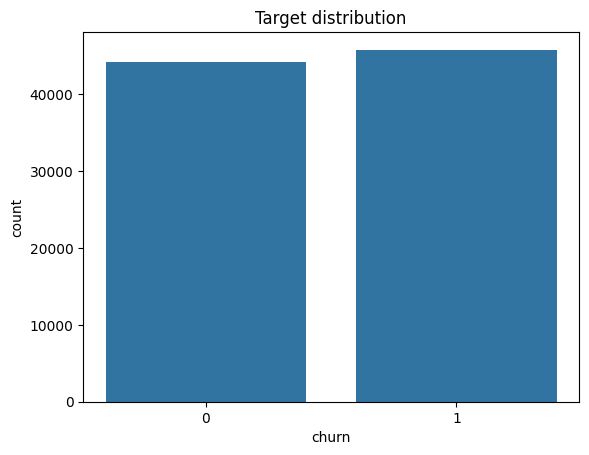

In [10]:
sns.countplot(data=df,x='churn')
plt.title('Target distribution')
plt.plot()

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

In [11]:
y.value_counts() / df.shape[0]  # Distribucion en % # dataset balanceado

1    0.508889
0    0.491111
Name: churn, dtype: float64

In [12]:
df2 = df.sample(frac=1, random_state=42)
X = df2[features]
y = df2[target]

# Split TRAIN-TEST

In [13]:
# HOLDOUT, 30 % para validar/test 
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size = 0.20, # tamaño del split aleatorio
                                        shuffle = False
                                        #stratify=y
                                    )

# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [14]:
# Estandarización: fit_transform() en train, transform() en test, lo usaremso para logisticregression
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)

In [15]:
X_train_std.head(3)

,mou,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_dat,recv_vce,recv_sms,custcare,ccrndmou,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,drop_blk,complete,callfwdv,callwait,months,uniqsubs,actvsubs,crclscod,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6rev,hnd_price,income,eqpdays,kids_suma,asl_flag_Y,refurb_new_R,hnd_webcap_U,hnd_webcap_WC,hnd_webcap_WCMB,creditcd_N,creditcd_U
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1089611,-0.019853,0.090431,-0.624185,-0.040396,-0.344088,-0.027406,-0.385221,-0.053014,-0.092905,0.068624,-0.022032,-0.309170,-0.351137,-0.274477,-0.676568,-0.075644,0.139546,-0.692310,-0.560683,-0.378743,-0.399338,-0.287075,-0.085485,-0.377623,-0.088535,-0.178380,-0.08554,-0.324942,-0.604018,-0.514052,-0.021759,-0.262354,-0.902406,0.510725,-0.573510,0.611209,-0.020048,-0.407421,-0.324233,1.138278,-0.125789,-0.015330,-0.495525,-0.390776,0.654836,0.128077,0.091593,-1.751185,-0.302210,-0.492382,-0.364156,-0.417059,-0.349038,-0.407514,0.578911,1.540607,-0.129248
1012457,0.007310,0.122753,-0.394160,-0.040396,0.751257,-0.027406,-0.358680,-0.053014,-0.092905,-0.079893,-0.022032,-0.122499,0.453539,0.068876,-0.293426,-0.075644,-0.107788,-0.516104,-0.538508,-0.294783,-0.259584,0.301864,-0.085485,0.164628,-0.088535,-0.492455,-0.08554,-0.552044,0.298052,-0.135501,-0.021759,-0.262354,0.961034,0.510725,1.000565,0.369328,-0.122887,-0.295234,-0.085368,-0.688997,-0.658835,-0.449105,-0.455496,-0.213685,-0.536301,0.123955,0.080171,0.571116,-0.857748,2.242756,-0.364156,-0.417059,-0.349038,2.453905,-1.727380,-0.649095,-0.129248
1053404,0.012192,0.077355,-0.164134,-0.040396,0.187937,-0.027406,0.145597,-0.053014,-0.092905,-0.001726,-0.022032,-0.246946,-0.324314,-0.274477,-0.417689,-0.075644,-0.067060,0.267031,-0.327456,1.006596,0.755079,-0.080947,-0.085485,-0.324331,-0.088535,0.172644,-0.08554,-0.225611,0.034032,0.005750,-0.021759,-0.198876,-0.792791,-0.626994,-0.573510,0.127448,-0.487924,-0.367517,-0.292940,-0.134369,-0.140297,-0.041601,-0.182922,0.046744,-0.103160,0.125248,0.093878,0.570930,-0.159358,-0.492382,-0.364156,-0.417059,-0.349038,-0.407514,0.578911,-0.649095,-0.129248


# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

LogisticRegression() clasificacion estandarizar

RandomForestClassifier() ensemble
XGBClassifier() ensemble
LGBMClassifier()ensemble
GradientBoostingClassifier ensemble

MLPClassifier neural network
GaussianNB probabilidad
KNeighborsClassifier() similitud


In [16]:
modelos=[RandomForestClassifier(),XGBClassifier(),LGBMClassifier(),GradientBoostingClassifier(),GaussianNB(),LogisticRegression(),MLPClassifier(),KNeighborsClassifier()]
label_.clear()
auc_train_.clear()
auc_valida_.clear()
stdmodels=[LogisticRegression(),MLPClassifier(),KNeighborsClassifier()]
for i in modelos:
  if i in stdmodels:
    model=i
    modelcomp=evaluate_classification(model,X= X_train_std,y=y_train)
  else:  
    model=i
    #model.fit(X, y)
    modelcomp=evaluate_classification(model,X= X_train,y=y_train)
  
#modelcomp.drop_duplicates(inplace = True)
modelcomp

[10:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model,AUC Train,AUC Cross-Valida
2,LGBMClassifier(),0.734927,0.667184
3,GradientBoostingClassifier(),0.679862,0.662974
1,"XGBClassifier(base_score=None, booster=None, c...",0.827888,0.652084
0,RandomForestClassifier(),1.000000,0.646467
5,LogisticRegression(),0.577330,0.575906
7,KNeighborsClassifier(),0.775920,0.552912
4,GaussianNB(),0.553307,0.552591
6,MLPClassifier(),0.556574,0.538603


## Hiperparametrizacion

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [17]:
#LGBM

parametros = {
  'num_leaves': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.8, 1],
    'feature_fraction': [0.5, 0.8, 1],
    'min_child_samples': [10, 50, 100]
}

In [ ]:
# parametros = {
#     'learning_rate': [0.05, 0.1, 0.2],  # Tasas de aprendizaje sugeridas
#     'max_depth': [3, 4, 5],  # Profundidades máximas sugeridas
#     'n_estimators': [100, 150, 200],  # Número de árboles sugeridos
#     'subsample': [0.8, 0.9, 1.0],  # Fracción de muestras para entrenar cada árbol
#     'min_samples_split': [2, 10, 20],  # Número mínimo de muestras requeridas para dividir un nodo interno
#     'min_samples_leaf': [1, 5, 10],  # Número mínimo de muestras requeridas para ser una hoja
#     'max_features': ['sqrt', 'log2', 'auto']  # Número de características a considerar para la mejor división
# }

In [ ]:
# parametros = {
#     "boosting_type ":["gbdt","dart","rf"],
#     "max_bin":[255,355,455],
#     'learning_rate':[0.05, 0.1, 0.2],
#     "num_iterations ":[200, 300, 400],
#     'num_leaves': [10, 50, 100]
# }

In [18]:
search_hp = RandomizedSearchCV(estimator=LGBMClassifier(),
                               param_distributions = parametros,
                               scoring='roc_auc',
                               cv = 5,                                    # numero de folds para cross-validation
                               n_iter = 10,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1
                               )

In [19]:
search_hp.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 36643, number of negative: 35357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9380
[LightGBM] [Info] Number of data points in the train set: 72000, number of used

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'feature_fraction': [0.5, 0.8, 1],
                                        'lambda_l1': [0, 0.1, 0.5, 1],
                                        'lambda_l2': [0, 0.1, 0.5, 1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 50, 100],
                                        'num_leaves': [10, 50, 100],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='roc_auc')

In [20]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best AUC_ROC:", search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: LGBMClassifier(feature_fraction=0.8, lambda_l1=1, lambda_l2=0.1, max_depth=10,
               min_child_samples=10, num_leaves=50, subsample=0.5)

 The best AUC_ROC: 0.6685187094380735

 The best parameters across ALL searched params:
 {'subsample': 0.5, 'num_leaves': 50, 'min_child_samples': 10, 'max_depth': 10, 'lambda_l2': 0.1, 'lambda_l1': 1, 'feature_fraction': 0.8}


## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [21]:
best_model= search_hp.best_estimator_ 

# TEST

* Evaluación de las métricas de performance en TEST.

In [22]:
y_train_pred = best_model.predict(X_train)                        # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)  

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [23]:
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]  

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [24]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)      # AUC en TRAIN
auc_test = roc_auc_score(y_test, y_test_pred_proba)         # AUC en TEST

In [25]:
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.7633
AUC Test: 0.6736


In [26]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

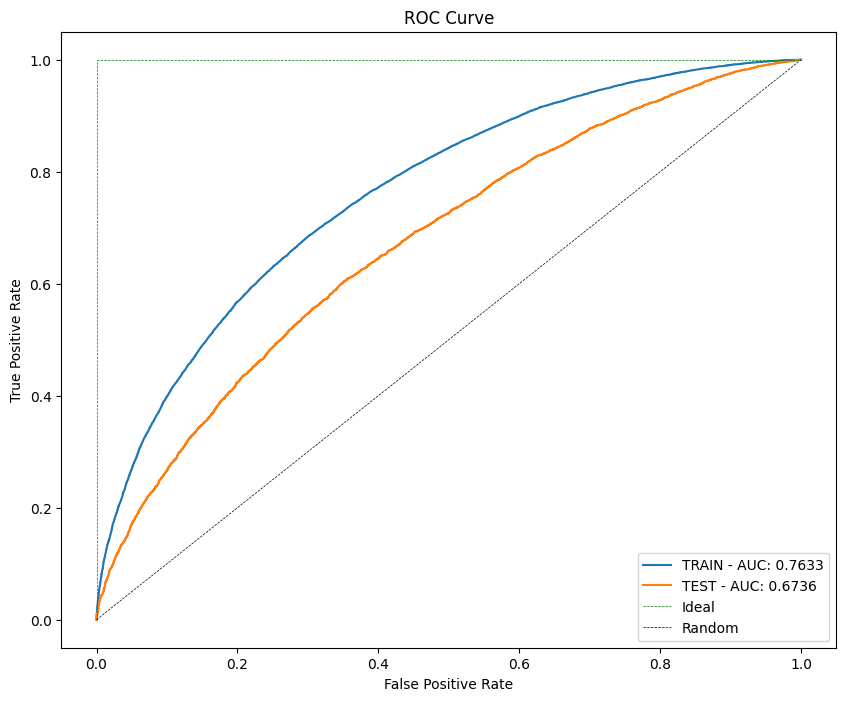

In [27]:
#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [28]:
cm_test = confusion_matrix(y_test, y_test_pred)

[]

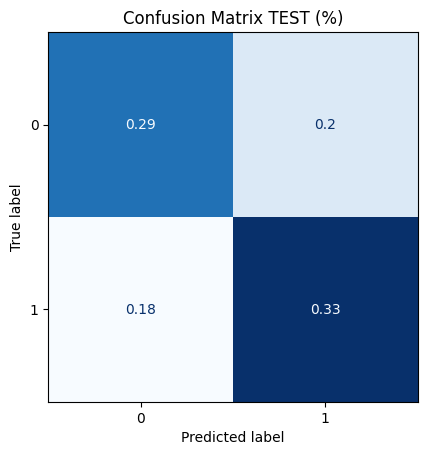

In [29]:
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

In [30]:

print('Accuracy:', round( accuracy_score(y_test, y_test_pred),4))
print('Precision:', round( precision_score(y_test, y_test_pred), 4))
print('Recall:', round( recall_score(y_test, y_test_pred), 4))
print('F1-score:', round(f1_score(y_test, y_test_pred), 4))

Accuracy: 0.6232
Precision: 0.6244
Recall: 0.6505
F1-score: 0.6372


# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

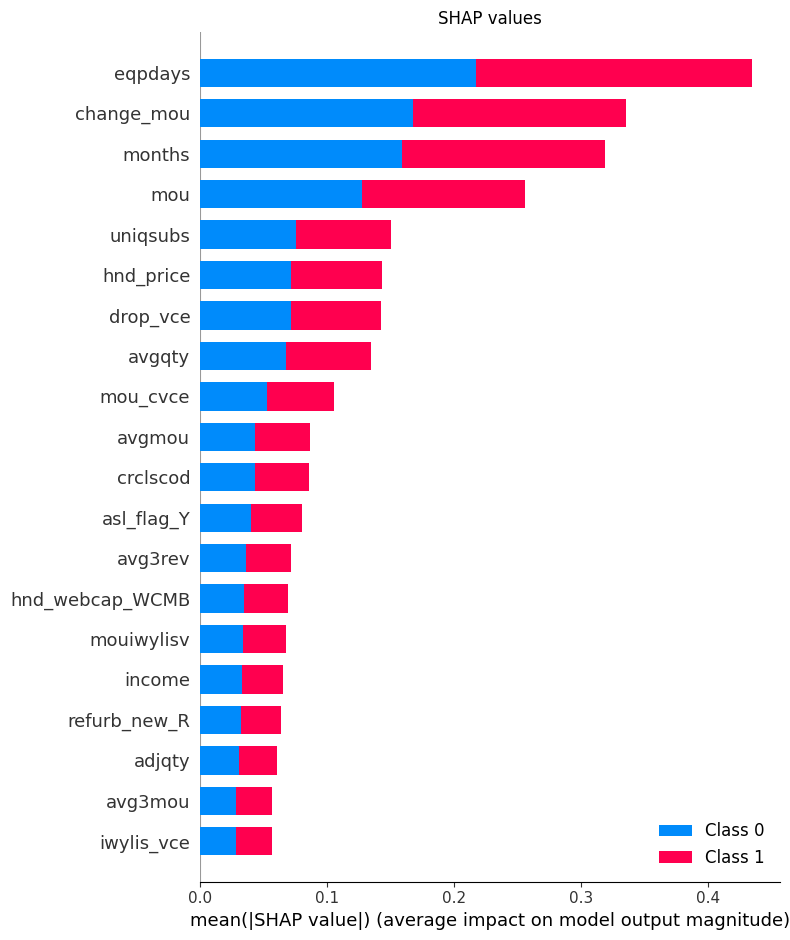

In [31]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

In [ ]:
shap.summary_plot(shap_values, X_test)